In [1]:
import matplotlib.pyplot as plt
import numpy as np
from neurodsp.sim import sim_powerlaw, sim_oscillation

from neurodsp.spectral import compute_spectrum
from eigvec.spectral import fft_to_eigvals_to_psd
from eigvec.circulant import sim_circulant

# Eigenspectra & Inversion

This notebook explains how the eigenvalues of circulant matrices are equal to power spectral density, e.g. eigenspectra.

The second part of the notebook explains how to convert backwards, from (manipulated) eigenspectra back to signal trials, using SVD.

# Eigenspectra

Eigenvalues (associated with Fourier mode eigenvectors) are equal to power spectral density when $X$ is circulant. The reason for this is that the eigenvalues (in covariance space) are the singular values (in signal space), so the eigenvalues are effectively squared Fourier coefficients.

Eigenspectra refers to these eigenvalues. Non-circulant components, e.g. fixed oscillations, are removed from eigenspectra.

In [2]:
def plot_results(cov, fs):
    
    # Compute PSD: covariance -> fft / eigenvalues -> psd 
    freqs, powers = fft_to_eigvals_to_psd(cov, fs)

    # Compute trial PSD
    freqs_welch, powers_welch = compute_spectrum(X, 1000)
    for i in range(100):
        p = powers_welch[i, 1:]
        p = p/p.mean()
        f = freqs_welch[1:]
        label = "Single Trial" if i == 0 else ""
        plt.loglog(f, p, color="C0", alpha=.2, label=label)
    
    # Plot
    plt.loglog(freqs, powers/powers.mean(),
               color="C1", label='Eigenvalue Spectrum')
    plt.legend()
    plt.title("PSD of Pink Noise Matrix")
    plt.xlabel("Frequency")
    plt.ylabel("Powers");

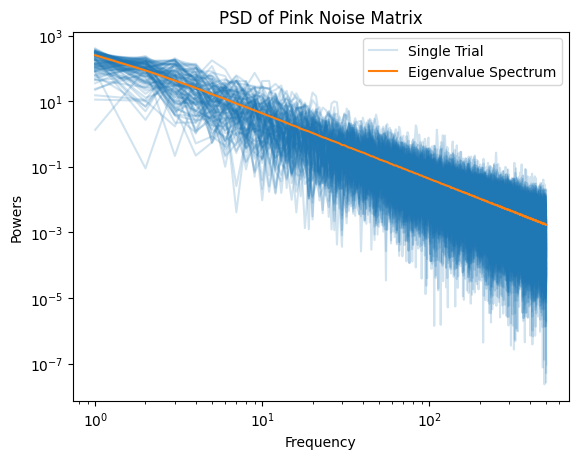

In [3]:
fs = 1000

X = np.array([
    sim_powerlaw(1, fs, exponent=-2)
    for i in range(10000)
])

cov = np.cov(X.T)

plot_results(cov, fs)

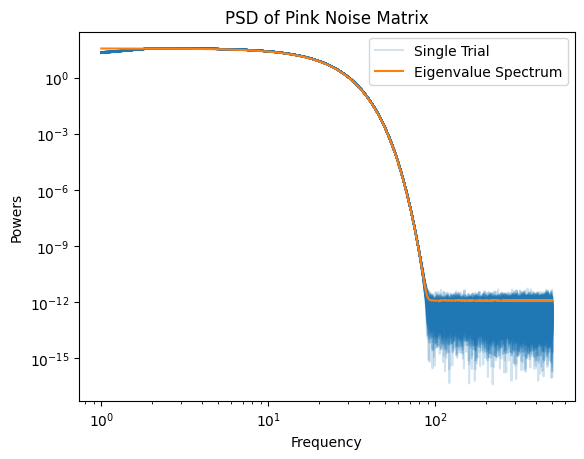

In [4]:
# Simulate temporally shifted gaussians as in Shinn 2024
sigma = 2
x = np.linspace(-100, 100, 1000)
gaussian = 10 * np.exp(-0.5 * (x/sigma)**2) / (sigma * np.sqrt(2 * np.pi))

X = sim_circulant(gaussian)
X += np.random.rand(*X.shape) * 1e-6

cov = np.cov(X.T)

plot_results(cov, fs)

Text(0.5, 1.0, 'PSD of Pink Noise + Oscillation Matrix')

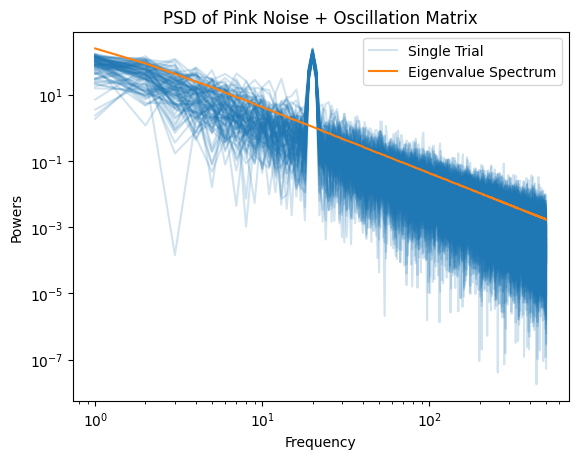

In [5]:
fs = 1000

X = np.array([
    sim_powerlaw(1, fs, exponent=-2) + sim_oscillation(1, fs, 20)
    for i in range(10000)
])

cov = np.cov(X.T)

plot_results(cov, fs)
plt.title("PSD of Pink Noise + Oscillation Matrix")

## Inversion

Text(0.5, 1.0, 'PSD of Trials')

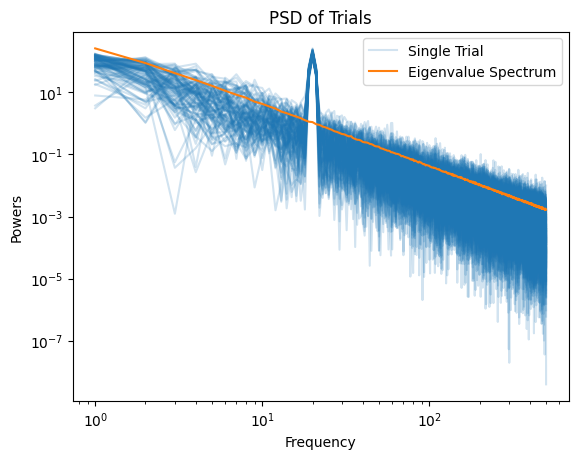

In [6]:
# Simulate
fs = 1000
n_trials = 2000

X_ap = np.array([
    sim_powerlaw(1, fs, exponent=-2)
    for i in range(n_trials)
])

X = X_ap + sim_oscillation(1, fs, 20)

cov = np.cov(X.T)

plot_results(cov, fs)
plt.title("PSD of Trials")

In [7]:
# Inversion
n = len(cov)
vecs = np.fft.fft(np.eye(n)) / np.sqrt(n)
vals = (vecs.conj() @ cov @ vecs).real
dvals = np.abs(np.diag(vals))

# SVD
S = np.diag(np.sqrt(dvals))
Sinv = np.diag(1/np.sqrt(dvals))

V = vecs

# Right singular vectors
U = X @ V
for i in range(U.shape[1]):
  U[:, i] = U[:, i] / np.linalg.norm(U[:, i])

# Reconstruct signals
X_ap_re = (U @ S @ V.conj()).real

Text(0.5, 1.0, 'Eigenspectrum inversion')

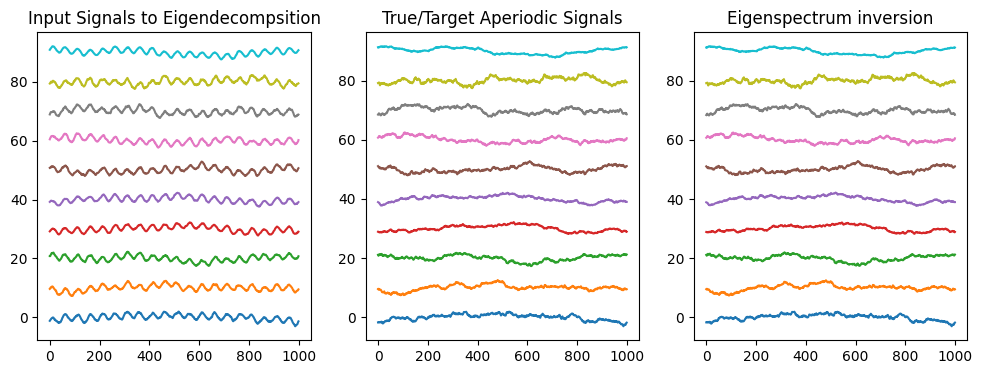

In [8]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))

for i in range(len(X_ap_re[::200])):

    xtrue = X[i]
    xtrue = (xtrue - xtrue.mean()) / xtrue.std()
    
    xaptrue = X_ap[i]
    xaptrue = (xaptrue - xaptrue.mean()) / xaptrue.std()

    xpred = X_ap_re[i]
    xpred = (xpred - xpred.mean()) / xpred.std()

    axes[0].plot(xtrue + i * 10)
    axes[1].plot(xaptrue + i * 10)
    axes[2].plot(xpred + i * 10)

axes[0].set_title('Input Signals to Eigendecompsition')
axes[1].set_title('True/Target Aperiodic Signals')
axes[2].set_title('Eigenspectrum inversion')